<a href="https://colab.research.google.com/github/youssefchkili/dl_pytorch/blob/main/cybersecurity_attacks_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler , LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv('sample_data/cybersecurity_intrusion_data.csv')

print(f"Dataset shape: {df.shape}")
print(df.describe())
print(df.info())





Dataset shape: (9537, 11)
       network_packet_size  login_attempts  session_duration  \
count          9537.000000     9537.000000       9537.000000   
mean            500.430639        4.032086        792.745312   
std             198.379364        1.963012        786.560144   
min              64.000000        1.000000          0.500000   
25%             365.000000        3.000000        231.953006   
50%             499.000000        4.000000        556.277457   
75%             635.000000        5.000000       1105.380602   
max            1285.000000       13.000000       7190.392213   

       ip_reputation_score  failed_logins  unusual_time_access  \
count          9537.000000    9537.000000          9537.000000   
mean              0.331338       1.517773             0.149942   
std               0.177175       1.033988             0.357034   
min               0.002497       0.000000             0.000000   
25%               0.191946       1.000000             0.000000   
5

attack_detected
0    5273
1    4264
Name: count, dtype: int64
attack_detected
0    0.552899
1    0.447101
Name: proportion, dtype: float64
session_id                0
network_packet_size       0
protocol_type             0
login_attempts            0
session_duration          0
encryption_used        1966
ip_reputation_score       0
failed_logins             0
browser_type              0
unusual_time_access       0
attack_detected           0
dtype: int64


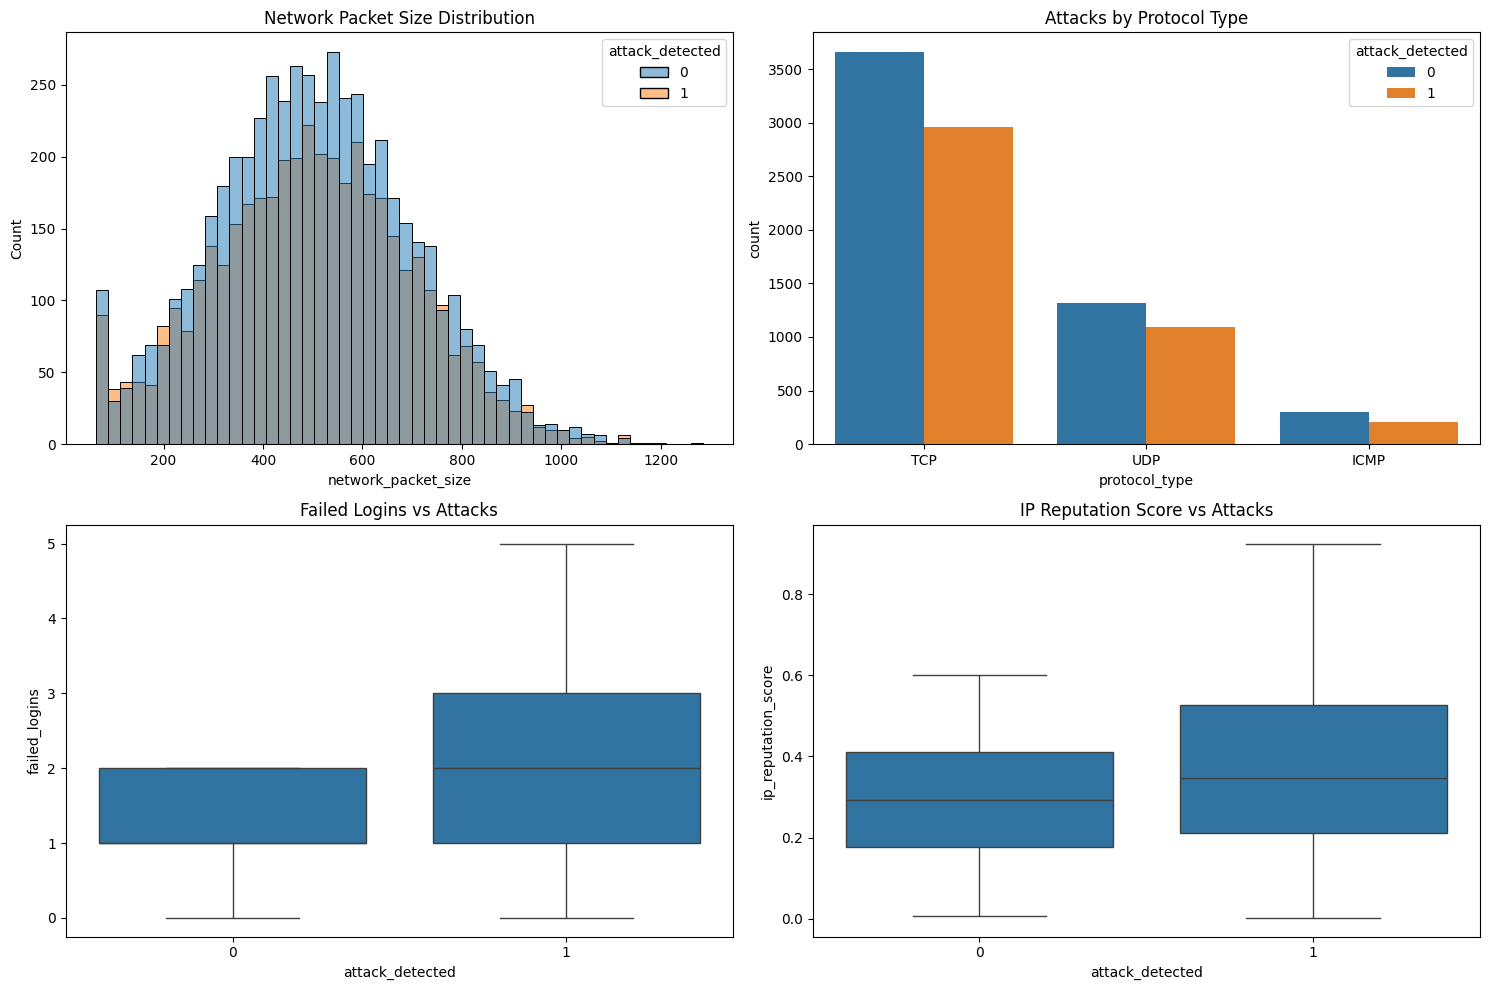

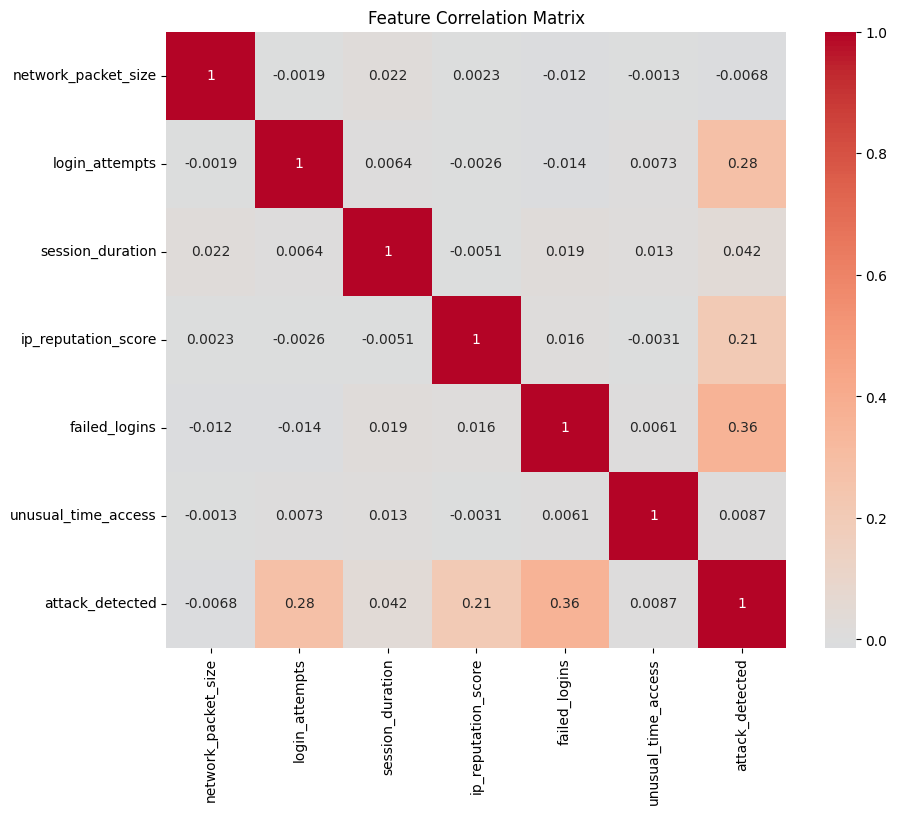

In [ ]:
print(df['attack_detected'].value_counts())
print(df['attack_detected'].value_counts(normalize=True))

print(df.isnull().sum())


# Visualize feature distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Network packet size distribution by attack
sns.histplot(data=df, x='network_packet_size', hue='attack_detected', bins=50, ax=axes[0,0])
axes[0,0].set_title('Network Packet Size Distribution')


# Protocol type vs attacks
sns.countplot(data=df, x='protocol_type', hue='attack_detected', ax=axes[0,1])
axes[0,1].set_title('Attacks by Protocol Type')

# Failed logins distribution
sns.boxplot(data=df, x='attack_detected', y='failed_logins', ax=axes[1,0])
axes[1,0].set_title('Failed Logins vs Attacks')

# IP Reputation Score
sns.boxplot(data=df, x='attack_detected', y='ip_reputation_score', ax=axes[1,1])
axes[1,1].set_title('IP Reputation Score vs Attacks')

plt.tight_layout()
plt.show()

numerical_cols = df.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(10, 8))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.show()

In [ ]:
X=df.drop(['attack_detected','session_id'],axis=1)

y=df['attack_detected'].values

categroical_cols = ['protocol_type','encryption_used','browser_type']
numerical_cols = ['network_packet_size', 'login_attempts', 'session_duration',
                  'failed_logins', 'unusual_time_access', 'ip_reputation_score']

label_encoders = {}
for col in categroical_cols:
    le = LabelEncoder()
    X[col]= le.fit_transform(X[col])
    label_encoders[col] = le

X=X.values
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42, stratify=y)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")



X_train shape: (7629, 9)
X_test shape: (1908, 9)


In [ ]:
train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
test_dataset = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))

batch_size=64
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False)


for batch_inputs, batch_labels in train_loader:
  print(f"Batch inputs shape: {batch_inputs.shape}")
  print(f"Batch labels shape: {batch_labels.shape}")
  break

Batch inputs shape: torch.Size([64, 9])
Batch labels shape: torch.Size([64])


In [ ]:
class IntrusionDetector(nn.Module):
  def __init__(self,input_size,hidden_size=64,dropout_rate=0.3):
    super(IntrusionDetector, self).__init__()

    #Layer1
    self.layer1 = nn.Linear(input_size,hidden_size)
    self.bn1 = nn.BatchNorm1d(hidden_size)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(dropout_rate)

    #Layer2
    self.layer2 = nn.Linear(hidden_size,hidden_size//2)
    self.bn2 = nn.BatchNorm1d(hidden_size//2)

    #outputLayer
    self.output = nn.Linear(hidden_size // 2,1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    # Layer 1
    x = self.layer1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.dropout(x)

    # Layer 2
    x = self.layer2(x)
    x = self.bn2(x)
    x = self.relu(x)
    x = self.dropout(x)

    # Output
    x = self.output(x)
    x = self.sigmoid(x)
    return x



In [ ]:
input_size = X_train.shape[1]
model = IntrusionDetector(input_size=input_size, hidden_size=128)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(f"Using device: {device}")

Using device: cpu


In [ ]:
#training loop
learning_rate = 0.001
num_epochs=50
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

history = {'train_loss':[],'val_loss':[], 'val_auc':[]}

for epoch in range(num_epochs):
  model.train()
  train_losses=[]

  for batch_inputs,batch_labels in train_loader:
    batch_inputs,batch_labels = batch_inputs.to(device),batch_labels.to(device)


    optimizer.zero_grad()

    pred = model(batch_inputs)
    loss = criterion(pred.squeeze(),batch_labels)

    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

  model.eval()
  val_losses = []
  val_preds = []
  val_targets = []

  with torch.no_grad():
    for batch_inputs,batch_labels in test_loader:
      batch_inputs,batch_labels = batch_inputs.to(device),batch_labels.to(device)
      pred = model(batch_inputs)
      loss = criterion(pred.squeeze(),batch_labels)

      val_losses.append(loss.item())

      val_preds.extend(pred.cpu().numpy())
      val_targets.extend(batch_labels.cpu().numpy())


  avg_train_loss = np.mean(train_losses)
  avg_val_loss = np.mean(val_losses)
  val_auc = roc_auc_score(val_targets, val_preds)

  scheduler.step(avg_validation_loss)


  history['train_loss'].append(avg_train_loss)
  history['val_loss'].append(avg_val_loss)
  history['val_auc'].append(val_auc)

  if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {avg_train_loss:.4f}, "
              f"Val Loss: {avg_val_loss:.4f}, "
              f"Val AUC: {val_auc:.4f}")

print("Training completed!")





Epoch [5/50], Train Loss: 0.4075, Val Loss: 0.3821, Val AUC: 0.8692
Epoch [10/50], Train Loss: 0.3846, Val Loss: 0.3727, Val AUC: 0.8706
Epoch [15/50], Train Loss: 0.3822, Val Loss: 0.3662, Val AUC: 0.8709
Epoch [20/50], Train Loss: 0.3882, Val Loss: 0.3701, Val AUC: 0.8705
Epoch [25/50], Train Loss: 0.3877, Val Loss: 0.3669, Val AUC: 0.8709
Epoch [30/50], Train Loss: 0.3775, Val Loss: 0.3673, Val AUC: 0.8710
Epoch [35/50], Train Loss: 0.3822, Val Loss: 0.3666, Val AUC: 0.8709
Epoch [40/50], Train Loss: 0.3890, Val Loss: 0.3666, Val AUC: 0.8711
Epoch [45/50], Train Loss: 0.3844, Val Loss: 0.3666, Val AUC: 0.8709
Epoch [50/50], Train Loss: 0.3869, Val Loss: 0.3669, Val AUC: 0.8707
Training completed!


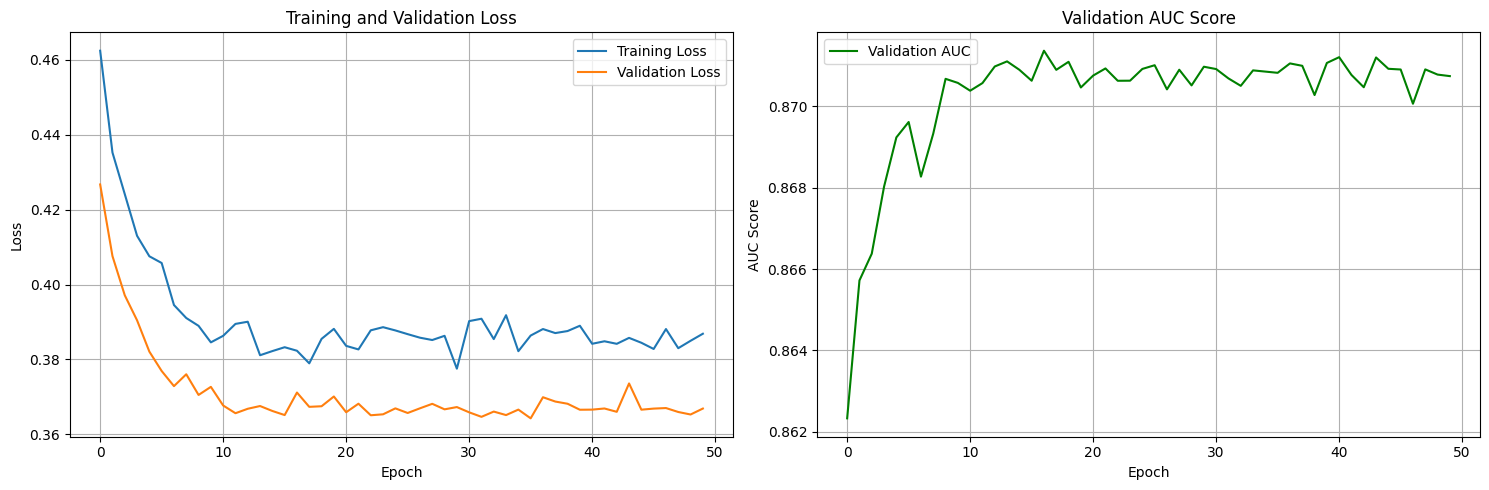

Classification Report:
              precision    recall  f1-score   support

      Normal       0.82      0.96      0.88      1055
      Attack       0.94      0.73      0.82       853

    accuracy                           0.86      1908
   macro avg       0.88      0.85      0.85      1908
weighted avg       0.87      0.86      0.86      1908



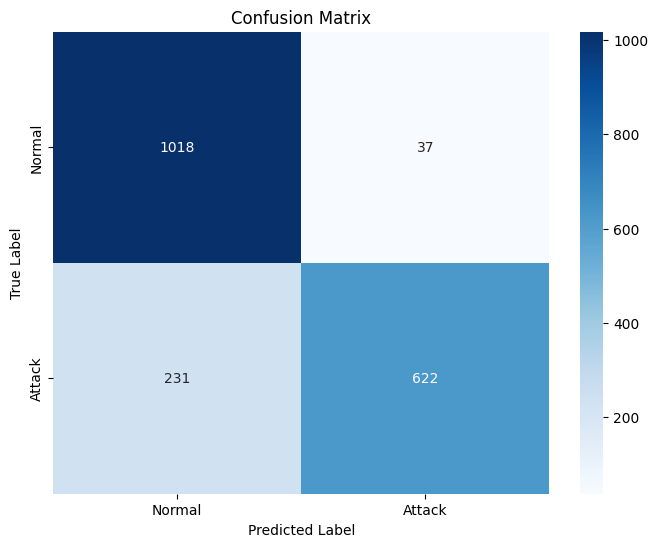

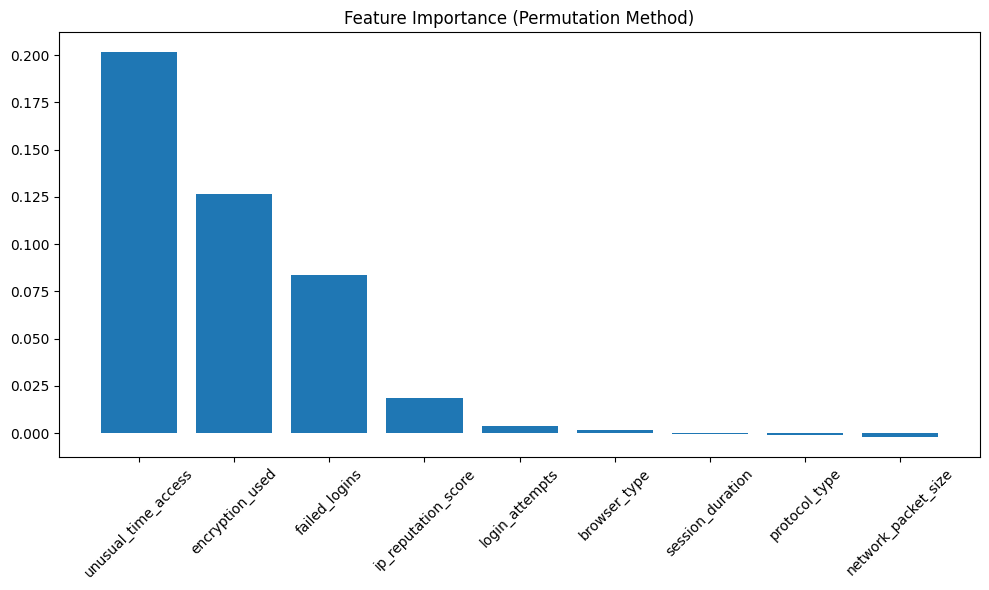

In [ ]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss curves
ax1.plot(history['train_loss'], label='Training Loss')
ax1.plot(history['val_loss'], label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

# AUC curve
ax2.plot(history['val_auc'], label='Validation AUC', color='green')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('AUC Score')
ax2.set_title('Validation AUC Score')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Final evaluation
model.eval()
all_preds = []
all_probs = []
all_targets = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        outputs = model(batch_X)
        probs = outputs.cpu().numpy()
        preds = (probs > 0.5).astype(int)

        all_probs.extend(probs)
        all_preds.extend(preds)
        all_targets.extend(batch_y.numpy())

# Convert to arrays
all_preds = np.array(all_preds).flatten()
all_probs = np.array(all_probs).flatten()
all_targets = np.array(all_targets).flatten()

# Classification report
print("Classification Report:")
print(classification_report(all_targets, all_preds,
                          target_names=['Normal', 'Attack']))

# Confusion Matrix
cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Attack'],
            yticklabels=['Normal', 'Attack'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Feature importance analysis (using permutation importance concept)
def get_feature_importance(model, X_test, y_test, feature_names):
    baseline_auc = roc_auc_score(y_test, model(torch.FloatTensor(X_test).to(device)).cpu().detach().numpy())
    importances = []

    for i in range(X_test.shape[1]):
        X_permuted = X_test.copy()
        np.random.shuffle(X_permuted[:, i])
        permuted_probs = model(torch.FloatTensor(X_permuted).to(device)).cpu().detach().numpy()
        permuted_auc = roc_auc_score(y_test, permuted_probs)
        importances.append(baseline_auc - permuted_auc)

    return np.array(importances)

feature_names = ['network_packet_size', 'protocol_type', 'encryption_used',
                'login_attempts', 'session_duration', 'failed_logins',
                'unusual_time_access', 'ip_reputation_score', 'browser_type']

importances = get_feature_importance(model, X_test, all_targets, feature_names)

plt.figure(figsize=(10, 6))
indices = np.argsort(importances)[::-1]
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45)
plt.title('Feature Importance (Permutation Method)')
plt.tight_layout()
plt.show()

In [ ]:
def predict_intrusion(network_packet_size, protocol_type, encryption_used,
                     login_attempts, session_duration, failed_logins,
                     unusual_time_access, ip_reputation_score, browser_type):
    """
    Predict whether a network session is an attack.

    Args: Raw feature values (same format as original CSV)
    Returns: Prediction (0=Normal, 1=Attack) and confidence score
    """
    model.eval()

    # Encode categoricals (using saved label encoders)
    protocol_encoded = label_encoders['protocol_type'].transform([protocol_type])[0]
    encryption_encoded = label_encoders['encryption_used'].transform([encryption_used])[0]
    browser_encoded = label_encoders['browser_type'].transform([browser_type])[0]

    # Create feature vector
    features = np.array([[
        network_packet_size, protocol_encoded, encryption_encoded,
        login_attempts, session_duration, failed_logins,
        unusual_time_access, ip_reputation_score, browser_encoded
    ]])

    # Scale features
    features_scaled = scaler.transform(features)

    # Predict
    with torch.no_grad():
        tensor = torch.FloatTensor(features_scaled).to(device)
        prob = model(tensor).cpu().item()

    prediction = 1 if prob > 0.5 else 0
    confidence = prob if prediction == 1 else 1 - prob

    return prediction, confidence

# Test with a sample
pred, conf = predict_intrusion(
    network_packet_size=0.05,
    protocol_type='TCP',
    encryption_used='AES',
    login_attempts=-0.2,  # Suspicious: high login attempts
    session_duration=0.36,
    failed_logins=-0.5,   # Suspicious: many failed logins
    unusual_time_access=-1.5,
    ip_reputation_score=-0.7,  # Suspicious: bad IP
    browser_type='Chrome'
)

print(f"Prediction: {'Attack' if pred == 1 else 'Normal'}")
print(f"Confidence: {conf:.2%}")

Prediction: Normal
Confidence: 90.28%


In [ ]:
# Test with completely random noise
model.eval()
with torch.no_grad():
    # Random input
    random_input = torch.randn(1, 9).to(device)
    pred1 = model(random_input).item()

    # Different random input
    random_input2 = torch.randn(1, 9).to(device)
    pred2 = model(random_input2).item()

print(f"Random 1: {pred1:.4f}")
print(f"Random 2: {pred2:.4f}")

# If both are ~0.99 or ~0.01 regardless of input, model is dead

Random 1: 0.2823
Random 2: 0.1373


In [ ]:
# Debug the prediction function
def debug_predict(network_packet_size, protocol_type, encryption_used,
                 login_attempts, session_duration, failed_logins,
                 unusual_time_access, ip_reputation_score, browser_type):

    # Encode
    protocol_encoded = label_encoders['protocol_type'].transform([protocol_type])[0]
    encryption_encoded = label_encoders['encryption_used'].transform([encryption_used])[0]
    browser_encoded = label_encoders['browser_type'].transform([browser_type])[0]

    # Create features (PRINT THIS!)
    features = np.array([[
        network_packet_size, protocol_encoded, encryption_encoded,
        login_attempts, session_duration, failed_logins,
        unusual_time_access, ip_reputation_score, browser_encoded
    ]])

    print(f"Raw features: {features}")

    # Scale (CRITICAL STEP!)
    features_scaled = scaler.transform(features)
    print(f"Scaled features: {features_scaled}")
    print(f"Scaled range: min={features_scaled.min():.2f}, max={features_scaled.max():.2f}")

    # Predict
    with torch.no_grad():
        tensor = torch.FloatTensor(features_scaled).to(device)
        prob = model(tensor).cpu().item()

    return prob

# Test
prob = debug_predict(512, 'TCP', 'AES', 1, 1800, 0, 0, 0.1, 'Chrome')
print(f"Probability: {prob:.4f}")

Raw features: [[5.12e+02 1.00e+00 0.00e+00 1.00e+00 1.80e+03 0.00e+00 0.00e+00 1.00e-01
  0.00e+00]]
Scaled features: [[ 5.38220435e-02 -3.83657525e-01 -2.03885377e+00 -1.00227763e+00
   2.29128653e+03 -1.86476198e+00 -1.46915596e+00 -6.88238655e-01
  -4.20871903e-01]]
Scaled range: min=-2.04, max=2291.29
Probability: 1.0000


In [ ]:
# Reconstruct the training dataframe to check statistics
train_df = pd.DataFrame(X_train, columns=[
    'network_packet_size', 'protocol_type', 'encryption_used',
    'login_attempts', 'session_duration', 'failed_logins',
    'unusual_time_access', 'ip_reputation_score', 'browser_type'
])

print("Training data statistics for session_duration:")
print(train_df['session_duration'].describe())

print("\nAll training means (should be ~0 after scaling):")
print(train_df.mean())

print("\nAll training stds (should be ~1 after scaling):")
print(train_df.std())

Training data statistics for session_duration:
count    7.629000e+03
mean    -2.400124e-08
std      1.000073e+00
min     -9.128937e-01
25%     -9.128937e-01
50%      3.605504e-01
75%      3.605504e-01
max      1.633995e+00
Name: session_duration, dtype: float64

All training means (should be ~0 after scaling):
network_packet_size    1.599692e-09
protocol_type         -3.048126e-07
encryption_used        1.984478e-09
login_attempts        -6.187820e-09
session_duration      -4.025169e-07
failed_logins          1.239908e-08
unusual_time_access    9.228602e-08
ip_reputation_score   -9.203406e-08
browser_type           1.353039e-07
dtype: float32

All training stds (should be ~1 after scaling):
network_packet_size    1.000067
protocol_type          1.000021
encryption_used        1.000092
login_attempts         1.000065
session_duration       1.000073
failed_logins          1.000065
unusual_time_access    1.000039
ip_reputation_score    1.000086
browser_type           1.000101
dtype: float